# 10. Spore Clusters

## Numerical experiments - Week 08/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [3]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting

## 1. Spore centroid generation

The following code computes the coordinates of a cluster of $n$ spherical spores, placing one spore at the centre of the lattice and the rest of the spores distributed evenly around it - in polar, triangular, tetrahedral, cubic, octahedral and icosahedral configurations.

In [81]:
spore_diameter = 15.0
spore_rad = spore_diameter / 2.0

L=64

spore_centers = setup_spore_cluster(12, L, spore_rad)

13×3 Matrix{Float64}:
 32.0     32.0     32.0
 32.0     24.114   44.7598
 32.0     24.114   19.2402
 32.0     39.886   19.2402
 44.7598  32.0     39.886
 44.7598  32.0     24.114
 19.2402  32.0     24.114
 19.2402  32.0     39.886
 39.886   44.7598  32.0
 24.114   44.7598  32.0
 24.114   19.2402  32.0
 39.886   19.2402  32.0
 32.0     39.886   44.7598

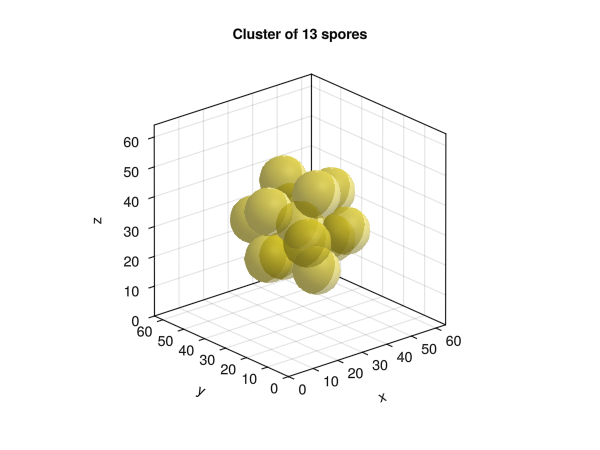

GLMakie.Screen(...)

In [82]:
plot_spheres(spore_centers, spore_rad, L, inline=true, title="Cluster of $(size(spore_centers)[1]) spores")

## 2. Measure of spore exposure

To measure the degree of coverage of a spore, a geometric construction is used that projects the areas of the surrounding spheres onto the central spore surface, here denoted as the sampling sphere, or sphere A. Let sphere B be a second reference sphere, with a centre positioned at a distance $d$ from the sampling sphere. One can construct a cone with a tip at the centre of the sphere A that touches sphere B tangentially. It thus intersects sphere A at a circular region, forming a spherical cap. The area of this cap can be computed by an integral over polar coordinates with a reference to the axis connecting the cenres of the two spheres:

$$
\begin{equation}
A=R^2\int_0^{2\pi}{\int_0^{\phi_0}{\sin{\phi}d{\phi}}d{\theta}},
\end{equation}
$$

where $\phi_0$ is the half-angle at the tip of the cone and defines the maximum that the vertical angle $\phi$ can reach and $\theta$ is the azimuthal angle around the reference axis. It can be noted that the farther sphere B is, the smaller its projection represented through the cap area would be. One can think of this projection as the "shadow" of sphere B onto sphere A. To capture even more detail about the proximity of surrounding spheres to the sampling sphere, each infinitesimal unit of area can be weighted by a function that depends on the projection distance between the surface areas. This can be pictured as the distance between two intersection points of a ray emanating from the centre of sphere A toward the sampled infinitesimal volume - one intersection through the surface of A and one through the surface of B. This distance can be expressed through the formula

$$
\begin{equation}
\Delta=d\cos{\phi}-\sqrt{R^2-d^2\sin^2{\phi}}-R
\end{equation}
$$

and used in a weighting function $w{(\phi)}=e^{-\Delta{(\phi)}}$, such that a weighted cap area is attained:

$$
\begin{equation}
A_w=R^2\int_0^{2\pi}{\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}d{\theta}}.
\end{equation}
$$

This has the property that the "shadow" intensity becomes 1 at $\Delta=0$ and decays to zero with increasing distance. Since the integrand is independent of the azimuthal angle $\theta$, the integral simplifies to

$$
\begin{equation}
A_w=2\pi R^2\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}.
\end{equation}
$$

The maximum limit for $\phi$ can be computed as $\phi_0=\arcsin{\frac{R}{d}}$. Thus, writing out the complete integral and summing for $M$ neighbours, one can obtain a measure for the surface coverage of a spore:

$$
\begin{equation}
Q=2\pi R^2\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}},
\end{equation}
$$

where $d_i$ are the corresponding distances from the sampling sphere centre to the neighbour centres. It is hereby assumed that only spheres that have an unobstructed "field of view" from the sampling sphere are considered. In the current experiments, these are furthermore only spheres that are directly adjacent to the central sphere.

The measure of coverage $Q$ is computed using the Julia `QuadGK` package and is demonstrated for different neighbour configurations.